USED CHATGPT TO DEBUG AND GET IDEAS TO WRITE THE CODE FOR BOTH PART ONE AND TWO


PART ONE

In [2]:
# Load dataset
import pandas as pd

dataFile = "/content/drive/MyDrive/project1data.csv"
dataSet = pd.read_csv(dataFile)

# Get shape and size of the dataset
dataSetShape = dataSet.shape
dataSetSize = dataSet.size

print("Shape of dataset:", dataSetShape)
print("Total size (data points):", dataSetSize)

Shape of dataset: (386, 10)
Total size (data points): 3860


In [3]:

print(dataSet.dtypes)


duplicateRows = dataSet.duplicated().sum()
print("Duplicate Rows:", duplicateRows)


dataSetCleaned = dataSet.drop_duplicates()

#Observations:
#Most columns are object (string) type, except deg-malig (integer).
#age, tumor-size, and inv-nodes should be converted to numeric values.
#11 duplicate rows were found and removed.

class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object
Duplicate Rows: 11


In [4]:
import numpy as np
import re


dataSetCleaned = dataSet.drop_duplicates().copy()

dataSetCleaned.replace({"?": np.nan, "*": np.nan}, inplace=True)


def getMidpoint(value):
    if isinstance(value, str) and '-' in value:
        nums = re.findall(r'\d+', value)
        if len(nums) == 2:
            return (int(nums[0]) + int(nums[1])) / 2
    return np.nan


numCols = ["age", "tumor-size", "inv-nodes"]
for col in numCols:
    dataSetCleaned.loc[:, col] = dataSetCleaned[col].apply(getMidpoint).astype(float)


for col in numCols:
    medianVal = dataSetCleaned[col].median()
    dataSetCleaned.loc[:, col] = dataSetCleaned[col].fillna(medianVal).astype(float)


print("Missing Values After Treatment:\n", dataSetCleaned.isnull().sum())

Missing Values After Treatment:
 class           0
age             0
menopause       0
tumor-size      0
inv-nodes       0
node-caps      12
deg-malig       0
breast          0
breast-quad     6
irradiat        0
dtype: int64


<ipython-input-4-c473da4cc8ba>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataSetCleaned.loc[:, col] = dataSetCleaned[col].fillna(medianVal).astype(float)
<ipython-input-4-c473da4cc8ba>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataSetCleaned.loc[:, col] = dataSetCleaned[col].fillna(medianVal).astype(float)
<ipython-input-4-c473da4cc8ba>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behav

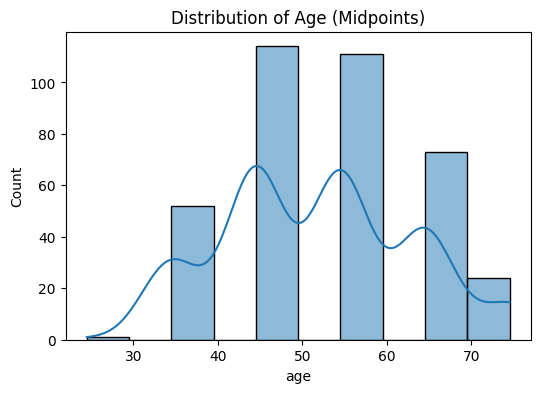

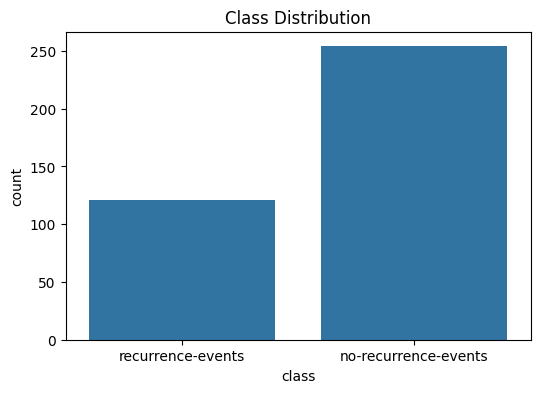

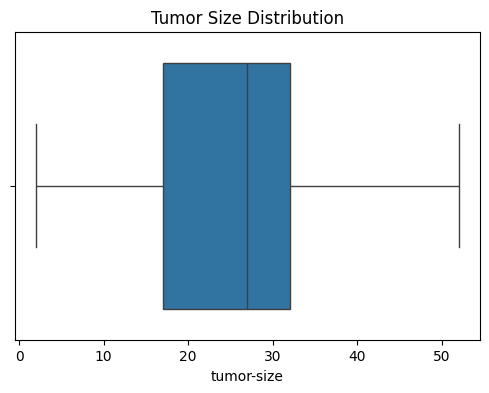

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Age
plt.figure(figsize=(6,4))
sns.histplot(dataSetCleaned["age"], bins=10, kde=True)
plt.title("Distribution of Age (Midpoints)")
plt.show()

print("\n\n")
# Countplot for Class (Target Variable)
plt.figure(figsize = (6,4))
sns.countplot(x = dataSetCleaned["class"])
plt.title("Class Distribution")
plt.show()

print("\n\n")

# Boxplot for Tumor Size
plt.figure(figsize = (6,4))
sns.boxplot(x=dataSetCleaned["tumor-size"])
plt.title("Tumor Size Distribution")
plt.show()


#Observations
#Age distribution: Majority of patients are between 40-60 years. The distribution is also slight right-skewed which means that most patients are older
#Class distribution: The dataset has an imbalance between recurrence and non-recurrence cases.
#Tumor size boxplot: Some outliers in tumor size, but mostly centered around small-to-medium sizes. The median tumor size is relatively small


In [6]:
# Perform One-Hot Encoding
dataSetEncoded = pd.get_dummies(dataSetCleaned, columns=["menopause", "node-caps", "breast", "breast-quad", "irradiat"], drop_first=True)
print(dataSetEncoded.head())



                  class   age tumor-size inv-nodes  deg-malig  menopause_lt40  \
0     recurrence-events  34.5       32.0       1.0          3           False   
1  no-recurrence-events  44.5       22.0       1.0          2           False   
2     recurrence-events  44.5       22.0       1.0          2           False   
3  no-recurrence-events  64.5       17.0       1.0          2           False   
4  no-recurrence-events  44.5        2.0       1.0          2           False   

   menopause_premeno  node-caps_yes  breast_right  breast-quad_left_low  \
0               True          False         False                  True   
1               True          False          True                 False   
2               True          False         False                  True   
3              False          False          True                 False   
4               True          False          True                 False   

   breast-quad_left_up  breast-quad_right_low  breast-quad_rig

PART TWO

In [7]:
from sklearn.model_selection import train_test_split

xFeatures = dataSetCleaned.drop(columns=["class"])
yTarget = dataSetCleaned["class"].map({"no-recurrence-events": 0, "recurrence-events": 1})

xTrain, xTest, yTrain, yTest = train_test_split(
    xFeatures, yTarget, test_size=0.2, random_state=42, stratify=yTarget
)

# Show class distribution
print("Class Distribution in Training Set:\n", yTrain.value_counts(normalize=True))
print("\nClass Distribution in Test Set:\n", yTest.value_counts(normalize=True))

# Observations:
# Stratified split ensures class balance is maintained.
# Reproducible split with random_state=42.


Class Distribution in Training Set:
 class
0    0.676667
1    0.323333
Name: proportion, dtype: float64

Class Distribution in Test Set:
 class
0    0.68
1    0.32
Name: proportion, dtype: float64


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

dataPath = "/content/drive/MyDrive/project1data.csv"
df = pd.read_csv(dataPath)

display(df.head())

print("Dataset columns:", df.columns.tolist())

df.columns = df.columns.str.strip().str.lower()

df = df.dropna()

categoricalColumns = df.select_dtypes(include=['object', 'category']).columns.tolist()
if not categoricalColumns:
    raise KeyError("No categorical column found for classification.")

targetColumn = categoricalColumns[-1]
print(f"Selected target column: {targetColumn}")

xFeatures = df.drop(columns=[targetColumn])
yTarget = df[targetColumn]

numFeatures = xFeatures.select_dtypes(include=['int64', 'float64']).columns.tolist()
catFeatures = xFeatures.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numFeatures),
    ('cat', OneHotEncoder(handle_unknown='ignore'), catFeatures)
])

xTrain, xTest, yTrain, yTest = train_test_split(xFeatures, yTarget, test_size=0.2, random_state=42, stratify=yTarget)

xTrainScaled = preprocessor.fit_transform(xTrain)
xTestScaled = preprocessor.transform(xTest)

knnModel = KNeighborsClassifier(n_neighbors=5)
svmLinearModel = SVC(kernel="linear", random_state=42)

knnModel.fit(xTrainScaled, yTrain)
svmLinearModel.fit(xTrainScaled, yTrain)
yPredKnn = knnModel.predict(xTestScaled)
yPredSvm = svmLinearModel.predict(xTestScaled)

paramGrid = {"n_neighbors": range(1, 20, 2)}
gridSearchKnn = GridSearchCV(KNeighborsClassifier(), paramGrid, cv=5, scoring="accuracy")
gridSearchKnn.fit(xTrainScaled, yTrain)

bestKnnModel = gridSearchKnn.best_estimator_
yPredKnnGrid = bestKnnModel.predict(xTestScaled)

knnReport = classification_report(yTest, yPredKnn, output_dict=True)
knnGridReport = classification_report(yTest, yPredKnnGrid, output_dict=True)
svmReport = classification_report(yTest, yPredSvm, output_dict=True)

knnDf = pd.DataFrame(knnReport).transpose()
knnGridDf = pd.DataFrame(knnGridReport).transpose()
svmDf = pd.DataFrame(svmReport).transpose()

print("\nKNN Classification Report:\n", knnDf)
print("\nKNN (Grid Search CV) Classification Report:\n", knnGridDf)
print("\nSVM (Linear) Classification Report:\n", svmDf)


,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


Dataset columns: ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']
Selected target column: irradiat

KNN Classification Report:
               precision    recall  f1-score   support
no             0.803030  0.883333  0.841270  60.00000
yes            0.363636  0.235294  0.285714  17.00000
accuracy       0.740260  0.740260  0.740260   0.74026
macro avg      0.583333  0.559314  0.563492  77.00000
weighted avg   0.706021  0.740260  0.718615  77.00000

KNN (Grid Search CV) Classification Report:
               precision    recall  f1-score    support
no             0.786667  0.983333  0.874074  60.000000
yes            0.500000  0.058824  0.105263  17.000000
accuracy       0.779221  0.779221  0.779221   0.779221
macro avg      0.643333  0.521078  0.489669  77.000000
weighted avg   0.723377  0.779221  0.704337  77.000000

SVM (Linear) Classification Report:
               precision    recall  f1-score    support
no      

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

knnModel = KNeighborsClassifier(n_neighbors=5)
knnModel.fit(xTrainScaled, yTrain)

yPredKnn = knnModel.predict(xTestScaled)
yPredKnnGrid = bestKnnModel.predict(xTestScaled)  # From previous GridSearchCV

logRegModel = LogisticRegression(random_state=42, max_iter=1000)
logRegModel.fit(xTrainScaled, yTrain)
yPredLogReg = logRegModel.predict(xTestScaled)

print("K-Nearest Neighbors Classification Report:\n", classification_report(yTest, yPredKnn))
print("KNN (Grid Search CV) Classification Report:\n", classification_report(yTest, yPredKnnGrid))
print("Logistic Regression Classification Report:\n", classification_report(yTest, yPredLogReg))


K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

          no       0.80      0.88      0.84        60
         yes       0.36      0.24      0.29        17

    accuracy                           0.74        77
   macro avg       0.58      0.56      0.56        77
weighted avg       0.71      0.74      0.72        77

KNN (Grid Search CV) Classification Report:
               precision    recall  f1-score   support

          no       0.79      0.98      0.87        60
         yes       0.50      0.06      0.11        17

    accuracy                           0.78        77
   macro avg       0.64      0.52      0.49        77
weighted avg       0.72      0.78      0.70        77

Logistic Regression Classification Report:
               precision    recall  f1-score   support

          no       0.81      0.98      0.89        60
         yes       0.75      0.18      0.29        17

    accuracy                           0.81      